In [ ]:
from ctypes import sizeof

import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve
from collections import OrderedDict



import matplotlib.pyplot as plt

import re

import string

import math

from wordcloud import WordCloud

from textwrap import wrap

from textblob import TextBlob

import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
#NLTK corpora needs to be unzipped in order to be used in text cleaning
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [ ]:
#Initializing the nltk stopwords and lemmatizer
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

In [ ]:
dfPandas = pd.read_csv('/kaggle/input/amazon-books-reviews/Books_rating.csv')

In [ ]:
df = dfPandas.drop(columns=['Id', 'Price', 'User_id', 'profileName','review/helpfulness', 'review/time', 'review/summary'])
print("Shape of data=>",df.shape)
print("\n\n\nEmpty Fields:")
print(df.isnull().sum())
df.dropna(inplace=True)

print("\n\n\nEmpty Fields Eliminated:")
print(df.isnull().sum())

#Here all unwanted columns are dropped and all empty review records are dropped

Shape of data=> (3000000, 3)



Empty Fields:
Title           208
review/score      0
review/text       8
dtype: int64



Empty Fields Eliminated:
Title           0
review/score    0
review/text     0
dtype: int64


In [ ]:
print("Shape of data=>",df.shape)

df.drop_duplicates(['review/text'], inplace=True)
df.dropna(subset=['review/text'], inplace = True)
print("\n\nEliminate duplicate and empty reviews:")
print("Shape of data=>",df.shape)

#If there are any duplicate or empty reviews, these are deleted here.

Shape of data=> (2999784, 3)


Eliminate duplicate and empty reviews:
Shape of data=> (2062627, 3)


In [ ]:
#Since the dataset is over 2 million records, in order to perform analysis with limited compute resources, the number of records is filtered
#This is done by filtering the dataset such that only books with more that 200 and less than 300 reviews are taken
df=df.groupby('Title').filter(lambda x:(300>len(x)>200)).reset_index(drop=True)
print('Number of books=>',len(df['Title'].unique()))

#This results in the filtering of 445 unique books with over 200 reviews each

Number of books=> 445


In [ ]:
#Here all unique titles are displayed in order to visualize the number of books being analyzed
df['Title'].unique()

array(['The Dharma Bums', 'Romeo and Juliet', 'Helter Skelter',
       'Finnegans Wake',
       'Hound of the Baskervilles (Lrs Large Print Heritage Series)',
       'THIRD SECRET: A Novel Of Suspense (H)', 'The Daughter of Time',
       'Winter Solstice', 'Summer of My German Soldier',
       'Chi Running: A Revolutionary Approach to Effortless, Injury-Free Running',
       'Till We Have Faces: A Myth Retold', 'Death du Jour',
       'Hyperspace: A Scientific Odyssey through Parallel Universes, Time Warps, and the Tenth Dimension',
       'The Bonfire of the Vanities', 'March',
       'American Theocracy: The Peril and Politics of Radical Religion, Oil, and Borrowed Money in the 21stCentury',
       'Sams Letters To Jennifer',
       "All the King's Men (Greatest Books of the 20th Century)",
       "A Connecticut Yankee in King Arthur's Court (Oxford World's Classics)",
       "Betty Crocker's cooky book", 'Practical Magic',
       'Cannery Row by Steinbeck',
       "Stitch 'N Bitch C

In [ ]:
#Here according to https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/
#Contractions dictionary is made and used to expand contracted words in the dataset
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not",
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['review/text']=df['review/text'].apply(lambda x:expand_contractions(x))

In [ ]:
# Turn all text to lowercase
df['cleaned']=df['review/text'].apply(lambda x: x.lower())

# Remove all digits and words containing digits
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

# Remove all punctuations
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

# Removing extra spaces
df['cleaned']=df['cleaned'].apply(lambda x: re.sub(' +',' ',x))


In [ ]:
def cleaningtext(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = " ".join([wn.lemmatize(word) for word in tokens if word not in stopword])
    return text

#This lemmatizes the words in the dataset such that only the base word remains
df['lemmatized'] = df['cleaned'].apply(lambda x: cleaningtext(x))
df.head()

Title  review/score  \
0  The Dharma Bums           5.0   
1  The Dharma Bums           5.0   
2  The Dharma Bums           5.0   
3  The Dharma Bums           5.0   
4  The Dharma Bums           4.0   

                                         review/text  \
0  Jack Kerouac was considered something of a rev...   
1  One of the most often used metaphors for inner...   
2  On the peaks of the High Siera, Kerouac is nar...   
3  Jack Kerouac is every wanderers' fantasy autho...   
4  I had been told for months on end by a Lit pro...   

                                             cleaned  \
0  jack kerouac was considered something of a rev...   
1  one of the most often used metaphors for inner...   
2  on the peaks of the high siera kerouac is narr...   
3  jack kerouac is every wanderers fantasy author...   
4  i had been told for months on end by a lit pro...   

                                          lemmatized  
0  jack kerouac considered something revolutionar...  
1  one often used metaphor inner growth travel jo...  
2  peak high siera kerouac narrator japhy ryder e...  
3  jack kerouac every wanderer fantasy author man...  
4  told month end lit professor pick road heard h...

In [ ]:
#Now that the dataset has been cleaned, we can visualize the highest rated books (on average)
#This is done using wordcloud
#However, the cleaned dataset needs to be organized by title and by the average score
#This is performed here
df_grouped=df[['Title','lemmatized']].groupby(by='Title').agg(lambda x:' '.join(x)).reset_index()
dftemp=df[['Title','review/score']].groupby(by='Title')['review/score'].mean().reset_index()

dftemp = dftemp.drop(columns=['Title'])

df_grouped['avgscore'] = dftemp['review/score']

df_grouped.sort_values(by='avgscore',ascending=False,inplace=True)

df_grouped.drop(columns=['avgscore'])

cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df_grouped['lemmatized'])

df_grouped.index = df_grouped['Title']
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names_out())
df_dtm.index=df_grouped.index

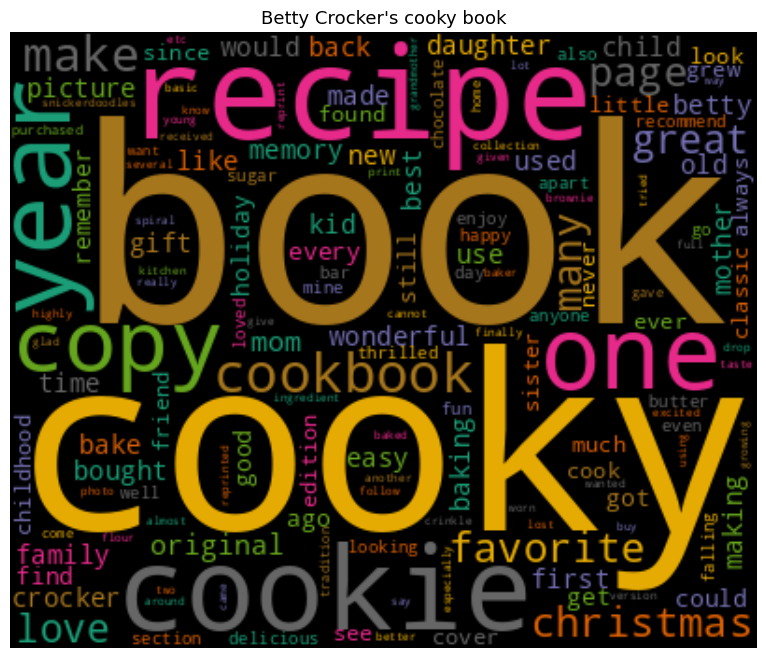

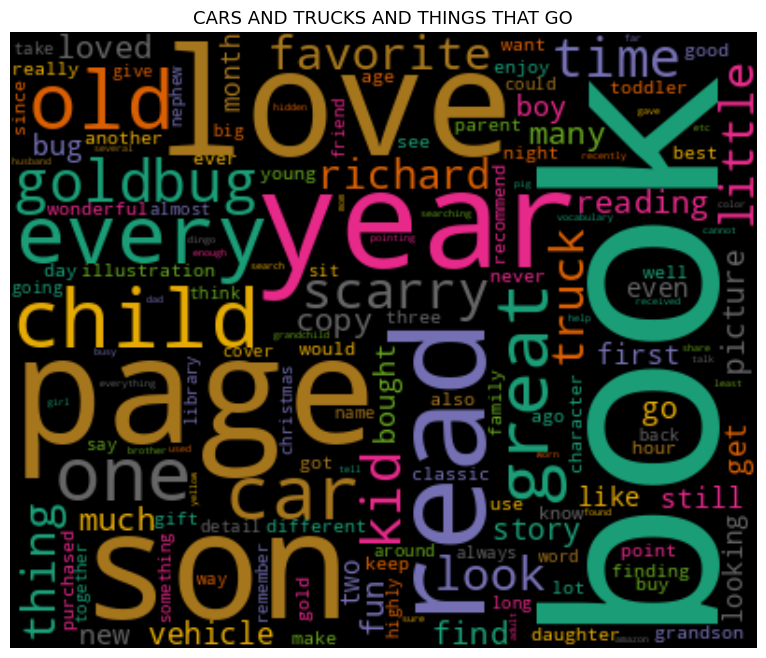

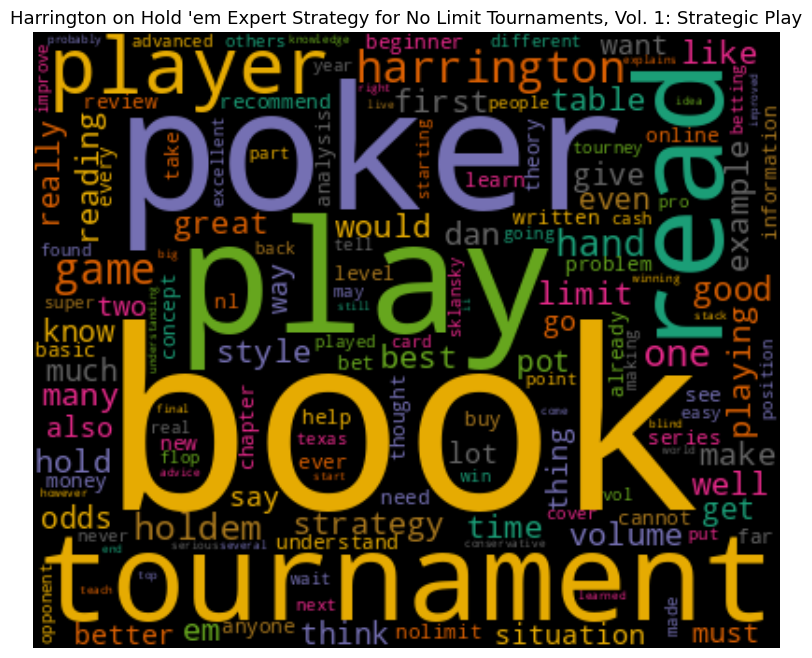

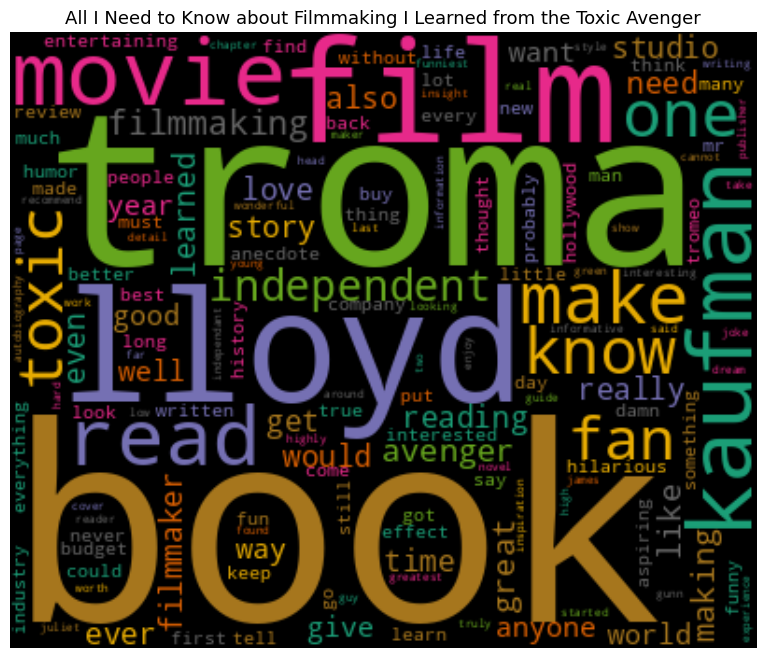

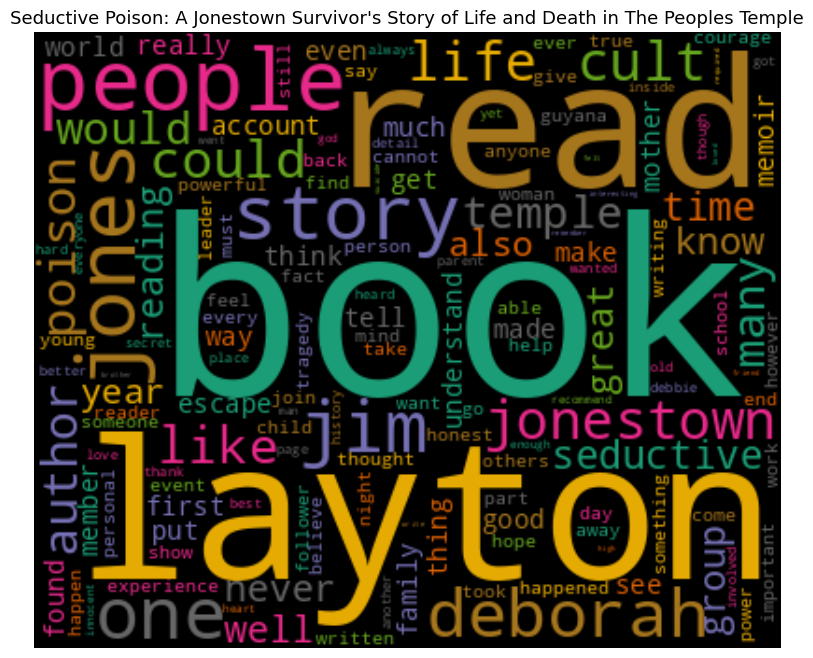

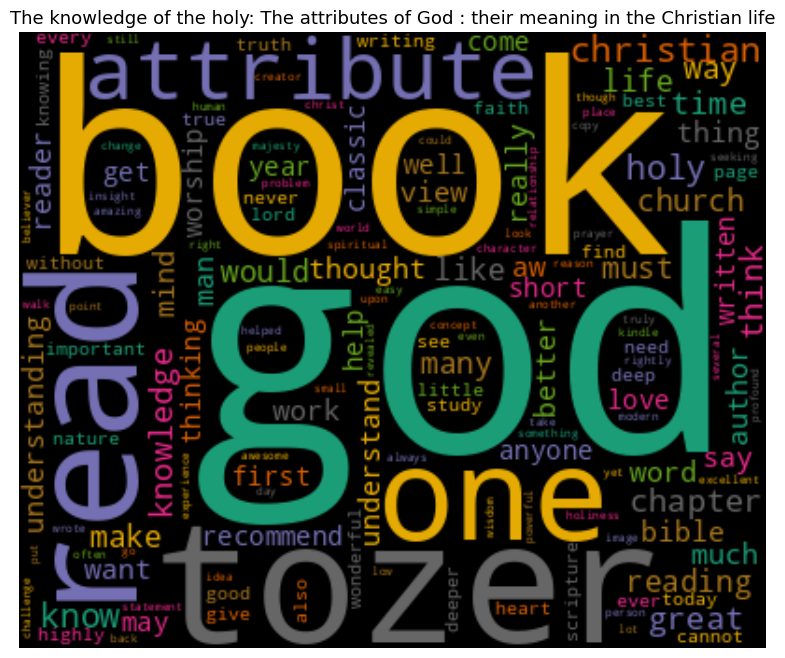

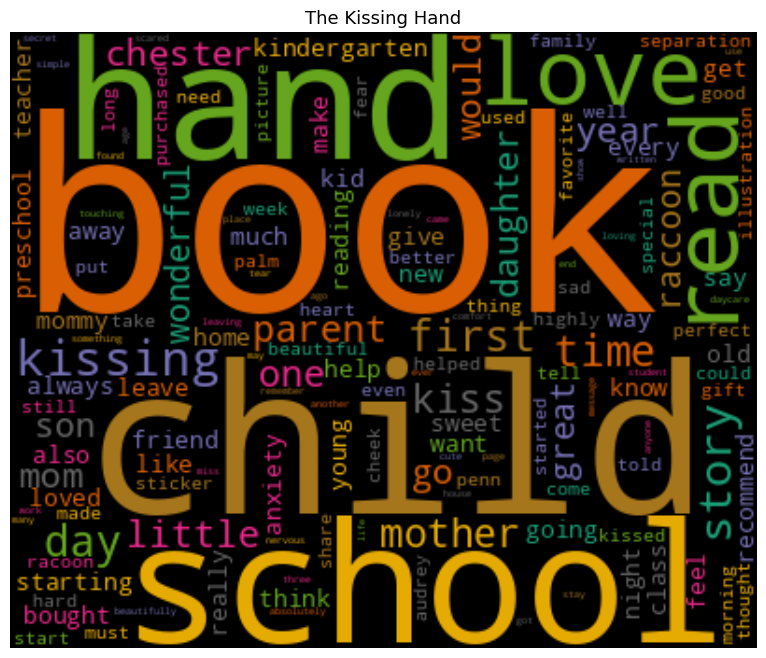

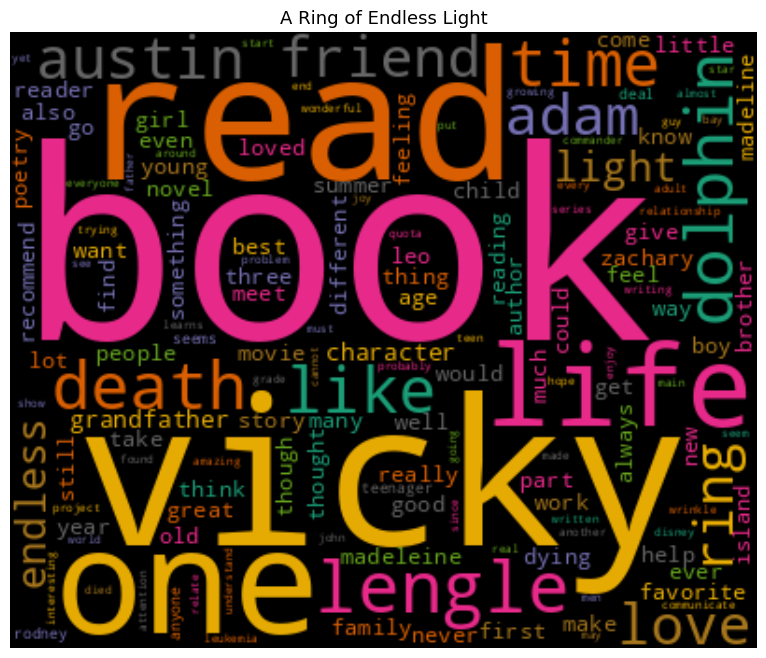

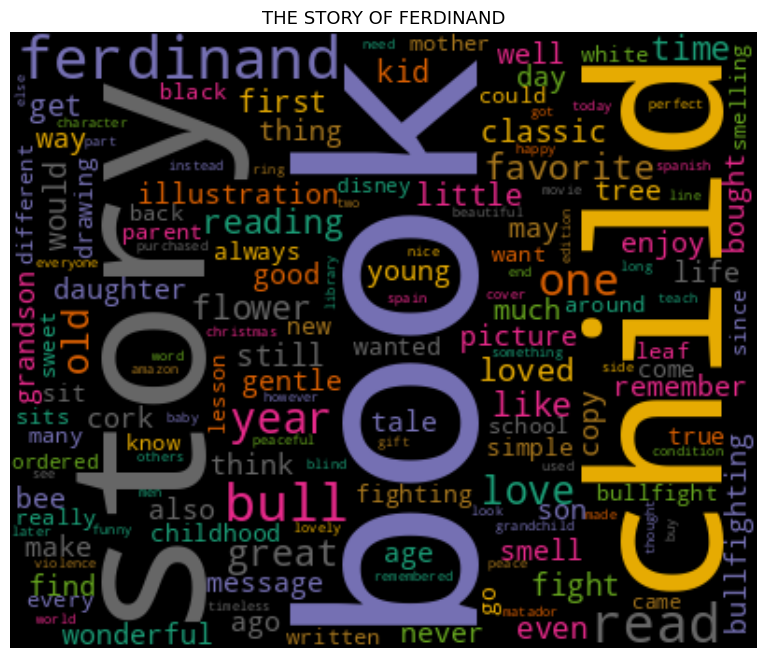

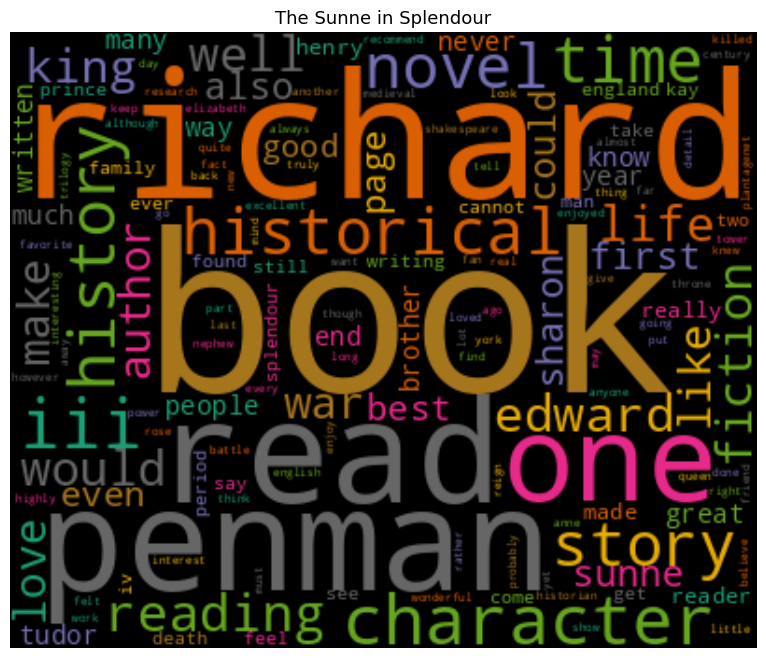

In [ ]:
#After that, the word clouds of the 10 best books are printed
def generate_wordcloud(data,title,counter):
    wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title,fontsize=13)
    plt.savefig('/kaggle/working/{}.png'.format(counter))
    plt.show()


# df_dtm=df_dtm.transpose()

# Plotting word cloud for each product
counter=0
for index,book in enumerate(df_dtm.columns):
    if(counter<10):
        counter = counter+1
        generate_wordcloud(df_dtm[book].sort_values(ascending=False),book,counter)

In [ ]:
# Instantiate CountVectorizer
# Here the min_df was determined after multiple iterations to try to improve accuracy
cv = CountVectorizer(ngram_range = (1,2), min_df = 10)
# Fit and transform data
word_significance = cv.fit_transform(df['lemmatized'])
print(cv.get_feature_names_out())
feature_names = cv.get_feature_names_out()
print(feature_names.shape)

['aa' 'aa milne' 'aaron' ... 'zoology' 'zoom' 'zora']
(100456,)


In [ ]:
tfidfvector = TfidfTransformer()

review_word_count_tf = tfidfvector.fit_transform(word_significance)


print(review_word_count_tf.shape)
print(cv.get_feature_names_out())

(107791, 100456)
['aa' 'aa milne' 'aaron' ... 'zoology' 'zoom' 'zora']


In [ ]:
df['ratingsuccess'] = np.where(df['review/score'] > 4, 1,0)


le = LabelEncoder()
label = le.fit_transform(df['ratingsuccess'])
y= np.array(label)

In [ ]:
df['ratingsuccess'].value_counts()

1    62813
0    44978
Name: ratingsuccess, dtype: int64

In [ ]:
df.head()

In [ ]:
print(y.shape)
print(review_word_count_tf.shape)
print(feature_names.shape)

(107791,)
(107791, 48275)
(48275,)


In [ ]:
#Initial cross validation to check accuracy and repeat this check to improve accuracy by feature set reduction/increase
rf = LogisticRegression(random_state = 20, solver = 'liblinear', max_iter = 500,n_jobs=-1)
k_fold = KFold(n_splits = 5)
cross_val_score(rf, review_word_count_tf, y, cv = k_fold, scoring = "accuracy", n_jobs=-1)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  

array([0.76404286, 0.76783561, 0.77822618, 0.77725206, 0.76505242])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(review_word_count_tf, y, test_size = 0.25,random_state=37,stratify = y, shuffle=True)

In [ ]:
models = []
# Append models
models.append(('NB', MultinomialNB()))
models.append(('LR', LogisticRegression(random_state = 20, solver = 'liblinear', max_iter = 500)))
models.append(('SVC', LinearSVC(random_state = 20, max_iter = 1000)))
models.append(('RF', RandomForestClassifier(random_state = 20,n_jobs=-1)))


NB: 0.765496 (0.004965)
LR: 0.780191 (0.002463)
SVC: 0.762713 (0.002803)
RF: 0.742872 (0.003122)


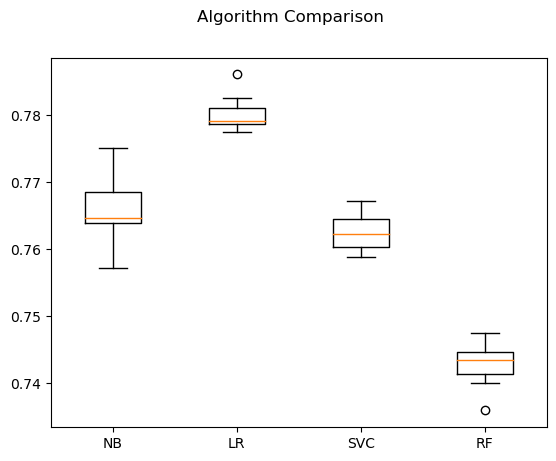

In [ ]:
#evaluate each algorithm
results = []
names = []
for name, model in models:
    #If not statified, shuffle is vital given data is ordered by labels.
    kfold = KFold(n_splits=10, shuffle=True, random_state=7)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

#boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()




In [ ]:
#With the above scores, it is clear that of the classifiers tested, Logistic regression bears the best accuracy at 78%
LRMod = LogisticRegression(random_state = 49, solver = 'liblinear', max_iter = 1000)
LRMod.fit(X_train, y_train)
print("The accuracy score for training data is as follows:")
print(LRMod.score(X_train, y_train))
print("\n\nThe accuracy score for testing data is as follows:")
print(LRMod.score(X_test, y_test))

The accuracy score for training data is as follows:
0.8498200215231992


The accuracy score for testing data is as follows:
0.7793528276681015


In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
y_train_predictions = LRMod.predict(X_train)

precision = precision_score(y_train, y_train_predictions)
recall = recall_score(y_train, y_train_predictions)
f1score = f1_score(y_train, y_train_predictions)
print("Scores for train data:")
print("The f1 Score is as follows: {}".format(f1score))
print("The Precision Score is as follows: {}".format(precision))
print("The Recall Score is as follows: {}".format(recall))

Scores for train data:
The f1 Score is as follows: 0.8763280398488351
The Precision Score is as follows: 0.8424237676504573
The Recall Score is as follows: 0.913075780089153


In [ ]:
y_test_predictions = LRMod.predict(X_test)

precision = precision_score(y_test, y_test_predictions)
recall = recall_score(y_test, y_test_predictions)
f1score = f1_score(y_test, y_test_predictions)
print("Scores for test data:")
print("The f1 Score is as follows: {}".format(f1score))
print("The Precision Score is as follows: {}".format(precision))
print("The Recall Score is as follows: {}".format(recall))

Scores for test data:
The f1 Score is as follows: 0.8181651376146788
The Precision Score is as follows: 0.7870212390421839
The Recall Score is as follows: 0.8518754378144303


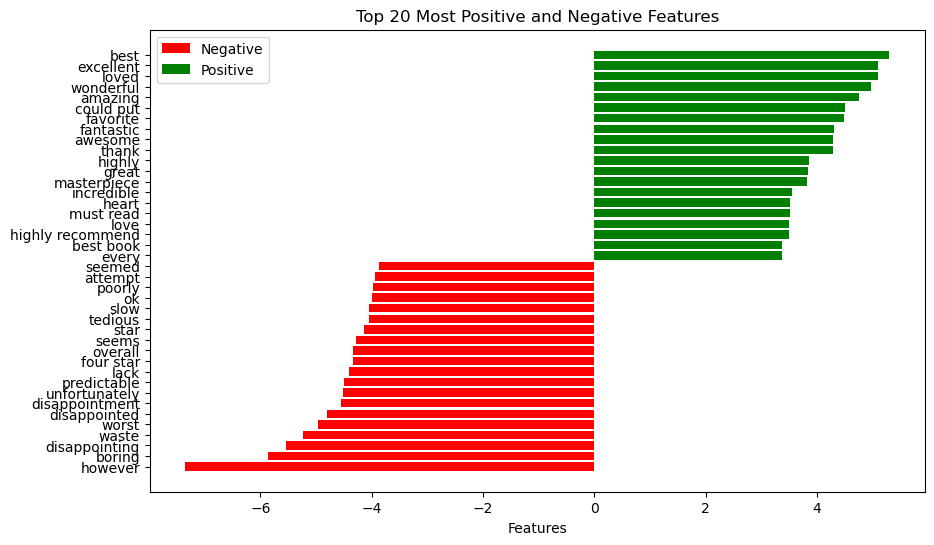

In [ ]:
#Feature importance
coefficients = LRMod.coef_[0]

# Get the indices of the 10 most positive and 10 most negative features
top_positive_indices = np.argsort(coefficients)[-20:]
top_negative_indices = np.argsort(coefficients)[:20]

# Map feature indices to feature names
# feature_names = vec.get_feature_names_out()
top_positive_features = [feature_names[i] for i in top_positive_indices]
top_negative_features = [feature_names[i] for i in top_negative_indices]

# Plot the features
plt.figure(figsize=(10, 6))
plt.barh(top_negative_features, coefficients[top_negative_indices], align='center', color='red', label='Negative')
plt.barh(top_positive_features, coefficients[top_positive_indices], align='center', color='green', label='Positive')
plt.yticks(top_negative_features + top_positive_features)
plt.xlabel('Features')
plt.title('Top 20 Most Positive and Negative Features')
plt.legend()
plt.show()